<a href="https://colab.research.google.com/github/Mmengyw/Capstone-Updated/blob/main/Image_Segmentation_Depth_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Tensorflow
import tensorflow.compat.v1 as tf
print(tf.__version__)

# I/O libraries
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

# Helper libraries
import matplotlib
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import cv2 as cv
from tqdm import tqdm
import IPython
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

# Comment this out if you want to see Deprecation warnings
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

2.7.0


In [ ]:
class DeepLabModel(object):
    """Class to load deeplab model and run inference."""

    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, tarball_path):
        """Creates and loads pretrained deeplab model."""
        self.graph = tf.Graph()
        graph_def = None

        # Extract frozen graph from tar archive.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')

        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')
        self.sess = tf.Session(graph=self.graph)

    def run(self, image, INPUT_TENSOR_NAME = 'ImageTensor:0', OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'):
        """Runs inference on a single image.

        Args:
            image: A PIL.Image object, raw input image.
            INPUT_TENSOR_NAME: The name of input tensor, default to ImageTensor.
            OUTPUT_TENSOR_NAME: The name of output tensor, default to SemanticPredictions.

        Returns:
            resized_image: RGB image resized from original input image.
            seg_map: Segmentation map of `resized_image`.
        """
        width, height = image.size
        target_size = (2049,1025)  # size of Cityscapes images
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        batch_seg_map = self.sess.run(
            OUTPUT_TENSOR_NAME,
            feed_dict={INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]  # expected batch size = 1
        if len(seg_map.shape) == 2:
            seg_map = np.expand_dims(seg_map,-1)  # need an extra dimension for cv.resize
        seg_map = cv.resize(seg_map, (width,height), interpolation=cv.INTER_NEAREST)
        return seg_map

In [ ]:
!git clone https://github.com/Mmengyw/Capstone-Updated.git
!ls
os.chdir("Capstone-Updated/Videos")

Cloning into 'Capstone-Updated'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 97 (delta 39), reused 14 (delta 5), pack-reused 18
Unpacking objects: 100% (97/97), done.
Capstone-Updated  sample_data


In [ ]:
import cv2
import imutils
import numpy as np

RADIUS_THRESHOLD = 5
COLOR = "blue"

def get_mask(frame, color=COLOR):
    # Hue color wheel https://cvexplained.wordpress.com/2020/04/28/color-detection-hsv/

    if color == "red":
        # lower boundary RED color range values; Hue (0 - 10)
        lower1 = np.array([0, 100, 25])
        upper1 = np.array([10, 255, 255])
        
        # upper boundary RED color range values; Hue (160 - 180)
        lower2 = np.array([160,100,20])
        upper2 = np.array([179,255,255])

        lower_mask = cv2.inRange(frame, lower1, upper1)
        upper_mask = cv2.inRange(frame, lower2, upper2)

        full_mask = lower_mask + upper_mask

    elif color == "yellow":
        lower = (20, 80, 20)
        upper = (40, 255, 255)

        full_mask = cv2.inRange(frame, lower, upper)

    elif color == "blue":
        lower = (100, 60, 20)
        upper = (140, 255, 255)

        full_mask = cv2.inRange(frame, lower, upper)

    elif color == "tennis":
        lower = (30, 80, 40)
        upper = (80, 255, 255)

        full_mask = cv2.inRange(frame, lower, upper)
    
    # elif color == "tennis":
    #     lower = (20, 80, 20)
    #     upper = (45, 255, 255)

    #    full_mask = cv2.inRange(frame, lower, upper)
    
    full_mask = cv2.erode(full_mask, None, iterations=2)
    full_mask = cv2.dilate(full_mask, None, iterations=1)
    # full_mask = cv2.morphologyEx(full_mask, cv2.MORPH_OPEN, np.ones((6, 6), np.uint8))

    return full_mask


def get_centroid(frame, color=COLOR):
    result = frame.copy()

    # Blur the frame and convert to hsv color space
    # frame = cv2.GaussianBlur(frame, (15, 15), 0)
    # frame = cv2.medianBlur(frame, 5)
    # frame = cv2.GaussianBlur(frame, (3, 3), 2)
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Get mask that removes pixels that are not that color
    mask = get_mask(hsv_frame, color)
    
    # Apply mask
    result = cv2.bitwise_and(result, result, mask=mask)

    # find contours in the mask and initialize the current
	# (x, y) center of the ball
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cnts = imutils.grab_contours(cnts)
    center = None
    radius = 0
    c = []
    
    if len(cnts) > 0:
        # find the largest contour in the mask
        c = max(cnts, key=cv2.contourArea)
        # compute the minimum enclosing circle and centroid
        # x, y is center of enclosing circle, NOT the centroid
        ((x, y), radius) = cv2.minEnclosingCircle(c)
        if radius < RADIUS_THRESHOLD:
            return None, None, None

        M = cv2.moments(c)
        center = [int(x), int(y)]

    return result, center, c, mask

In [ ]:
MODEL_NAME = 'mobilenetv2_coco_cityscapes_trainfine'
#MODEL_NAME = 'xception65_cityscapes_trainfine'

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_cityscapes_trainfine':
        'deeplabv3_mnv2_cityscapes_train_2018_02_05.tar.gz',
    'xception65_cityscapes_trainfine':
        'deeplabv3_cityscapes_train_2018_02_06.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME], download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


In [ ]:
def create_label_colormap():
    """Creates a label colormap used in Cityscapes segmentation benchmark.

    Returns:
        A Colormap for visualizing segmentation results.
    """
    colormap = np.array([
        [128,  64, 128],
        [244,  35, 232],
        [ 70,  70,  70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170,  30],
        [220, 220,   0],
        [107, 142,  35],
        [152, 251, 152],
        [ 70, 130, 180],
        [220,  20,  60],
        [255,   0,   0],
        [  0,   0, 142],
        [  0,   0,  70],
        [  0,  60, 100],
        [  0,  80, 100],
        [  0,   0, 230],
        [119,  11,  32],
        [  0,   0,   0]], dtype=np.uint8)
    return colormap


def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
            is the color indexed by the corresponding element in the input label
            to the PASCAL color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
            map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')
    return colormap[label]


def vis_segmentation(image, seg_map):
    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(20, 4))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()


LABEL_NAMES = np.asarray([
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck',
    'bus', 'train', 'motorcycle', 'bicycle', 'void'])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

Get Segmentation Data


In [ ]:
def vis_segmentation_stream_2(image, seg_map, seg_data, index):
    """Visualizes segmentation overlay view and stream it with IPython display."""
    fig = plt.figure(figsize= (12,6))
    # ax1 = fig.add_subplot(1,2,1)
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(seg_image)
    # ax1.imshow(seg_image, alpha=0.7)
    # ax1.axis('off')
    # ax1.grid('off')
    # plt.title('segmentation overlay | frame #%d'%index)
    

    # ax2 = fig.add_subplot(1,2,2)
    # unique_labels = np.unique(seg_map)
    # ax2.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    # ax2.yaxis.tick_right()
    # plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    # plt.xticks([], [])
    # ax2.tick_params(width=0.0)
    # plt.grid('off')
    # plt.tight_layout()

    for i in range(len(seg_map)):
        for j in range(len(seg_map[i])):
                seg_data[i][j] = LABEL_NAMES[seg_map[i][j]]
    # print(seg_data)
    return seg_data
def run_visualization_video_2(frame, index):
    """Inferences DeepLab model on a video file and stream the visualization."""
    original_im = Image.fromarray(frame[..., ::-1])
    seg_map = MODEL.run(original_im)
    seg_data = np.full((len(seg_map),len(seg_map[0])),'nullvoidnada')
    filled_seg_data = vis_segmentation_stream_2(original_im, seg_map, seg_data, index)
    # print(filled_seg_data)
    return filled_seg_data

[['building' 'building' 'building' ... 'vegetation' 'vegetation'
  'vegetation']
 ['building' 'building' 'building' ... 'vegetation' 'vegetation'
  'vegetation']
 ['building' 'building' 'building' ... 'vegetation' 'vegetation'
  'vegetation']
 ...
 ['car' 'car' 'car' ... 'car' 'car' 'car']
 ['car' 'car' 'car' ... 'car' 'car' 'car']
 ['car' 'car' 'car' ... 'car' 'car' 'car']]


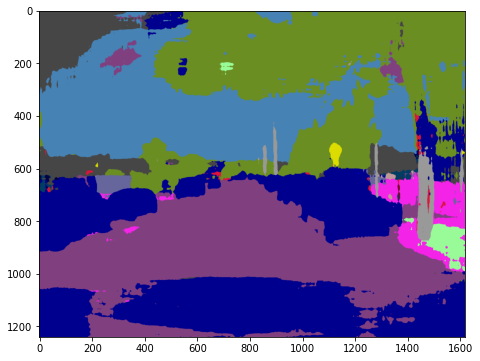

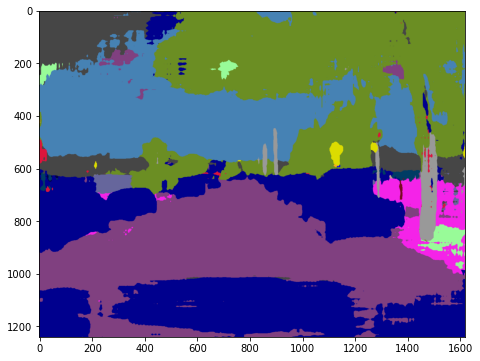

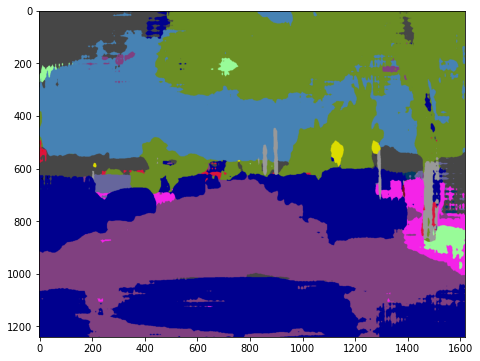

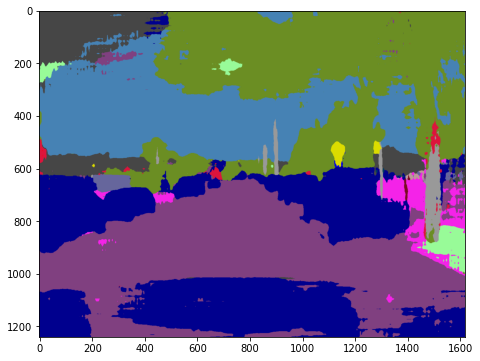

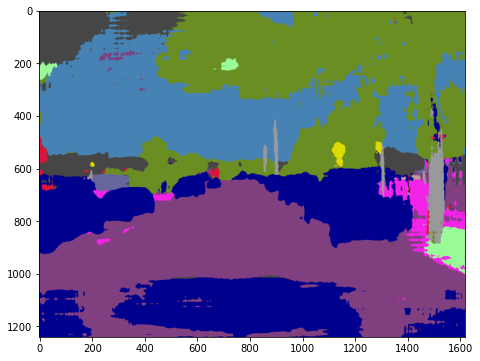

In [ ]:
video = cv.VideoCapture('test12.mp4')
num_frames = 5  # uncomment to use the full sample video
try:
    for i in range(num_frames):
        _, frame = video.read()
        if not _: break
        filled_seg_DATA = run_visualization_video_2(frame, i)
        print(filled_seg_DATA)
        IPython.display.clear_output(wait=True)
except KeyboardInterrupt:
    plt.close()
    print("Stream stopped.")
print(filled_seg_DATA)

In [ ]:
# Tensorflow
import tensorflow.compat.v1 as tf
print(tf.__version__)

# I/O libraries
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

# Helper libraries
import matplotlib
import torch
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import cv2 as cv
from tqdm import tqdm
import IPython
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

# Comment this out if you want to see Deprecation warnings
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

2.7.0


In [ ]:
pip install timm

     |████████████████████████████████| 431 kB 5.3 MB/s 


In [ ]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

Downloading: "https://github.com/intel-isl/MiDaS/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/intel-isl/DPT/releases/download/1_0/dpt_large-midas-2f21e586.pt" to /root/.cache/torch/hub/checkpoints/dpt_large-midas-2f21e586.pt


  0%|          | 0.00/1.28G [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (fc2): Linear(in_features=4

In [ ]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [ ]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
nb_photo=34

equiv=[[0.001,51],    #for extrapolation
      [0.1,45],     #premier plan
      [0.9,42.3],
      [1.8,37.4],
      [2.7,28.7],
      [3.6,24.443365],
      [4.5,22.058018],
      [5.4,15.317413],
      [6.3,14.677493],
      [7.2,10.969739],
      [8.1,10.883035],
      [9,9.883035],
      [9.9,8.058806],
      [10.8,7.5158963],
      [11.7,7.098169],
      [12.6,6.111024],
      [13.5,5.6323136],
      [14.4,5.2216917],
      [15.3,5],
      [16.2,4.9529667],
      [17.1,4.8],
      [18,4.7],
      [18.9,4.6],
      [19.8,4.5],
      [20.7,4.4],
      [21.6,4.3],
      [22.5,4.2],
      [23.4,4.1],
      [24.3,4],
      [25.2,3.9],
      [26.1,3.8],
      [27,3.7],
      [27.9,3.6],
      [28.8,3.5],
      [29.7,3.2],
      [30.6,3],
      [60,0.0],
       
      [120,-6],    #horizon
       
      [40,1.98],
      [50,1.33]
       
       ]   #for extrapolation

#=========================================================================================

equiv2=[[1,41.05157], #1yard  0302
        [1,42.18351],
        [1,31.304607],
        [1,25.090006],
        [1,23.275448], #5yard 0306
        [1,19.171278],
        [1,17.472866],
        [1,16.775742],
        [1,15.820402],
        [1,15.538459], #10yard  0311
        [1,14.466544],
        [1,12.707126],
        [1,10.957558],
      

        [1,6.023936],#'''inacurrate'''
        [1,9.797453],  #15yard 0316
        [1,7.2150397],
        [1,6.3944836],
        [1,8.514687],
        [1,7.735209],
        ]

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline
equiv=np.asarray(equiv)
X = equiv[:,1]    #midas output
Y=equiv[:,0]     #meters
new_length = 25
new_x = np.linspace(X.min(), X.max(), new_length)
conv=sp.interpolate.interp1d(X, Y, kind='linear')

coef_expand=[[-5,-1],
        [1,10],
        [5,25],
        [10,35],
        [15,42],
        [35,43],
        [45,50],
        [51,51]
        ]
coef_expand=np.asarray(coef_expand)
X = coef_expand[:,0]    #midas output
Y=coef_expand[:,1]      #meters
expand=sp.interpolate.interp1d(X, Y, kind='cubic')

[[2.5123 2.5123 2.5123 ... 2.5123 2.5123 2.5123]
 [2.5123 2.5123 2.5123 ... 2.5123 2.5123 2.5123]
 [2.5123 2.5123 2.5123 ... 2.5123 2.5123 2.5123]
 ...
 [2.5123 2.5123 2.5123 ... 2.5123 2.5123 2.5123]
 [2.5123 2.5123 2.5123 ... 2.5123 2.5123 2.5123]
 [2.5123 2.5123 2.5123 ... 2.5123 2.5123 2.5123]]


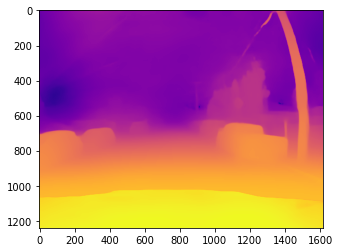

In [ ]:
!ls
holder = np.full((len(filled_seg_DATA),len(filled_seg_DATA[0])),2.5123)
def depth_prediction_stream(image, frame, index):
    """Visualizes segmentation overlay view and stream it with IPython display."""
    img = frame
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    input_batch = transform(img).to(device)

    with torch.no_grad():
      prediction = midas(input_batch)

      prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
      ).squeeze()

    output = prediction.cpu().numpy()
    output = 50*output/np.max(output)     #normalization due to the 
    plt.imshow(expand(output), cmap='plasma')
    holder = np.copy(output)
    # # Show visualization in a streaming fashion.
    # f = BytesIO()
    # plt.savefig(f, format='jpeg')
    # IPython.display.display(IPython.display.Image(data=f.getvalue()))
    # f.close()
    # plt.close()

def depth_prediction_video(frame, index):
    """Inferences DeepLab model on a video file and stream the visualization."""
    original_im = Image.fromarray(frame[..., ::-1])
    depth_prediction_stream(original_im, frame, index)
    

SAMPLE_VIDEO = 'test12.mp4'
print('running deeplab on the sample video...')

video = cv.VideoCapture(SAMPLE_VIDEO)
# num_frames = 598  # uncomment to use the full sample video
num_frames = 5

try:
    for i in range(num_frames):
        _, frame = video.read()
        if not _: break
        depth_prediction_video(frame, i)
        IPython.display.clear_output(wait=True)
except KeyboardInterrupt:
    plt.close()
    print("Stream stopped.")
print(holder)

[[['building' 'building' 'building' ... 'vegetation' 'vegetation'
   'vegetation']
  ['building' 'building' 'building' ... 'vegetation' 'vegetation'
   'vegetation']
  ['building' 'building' 'building' ... 'vegetation' 'vegetation'
   'vegetation']
  ...
  ['car' 'car' 'car' ... 'car' 'car' 'car']
  ['car' 'car' 'car' ... 'car' 'car' 'car']
  ['car' 'car' 'car' ... 'car' 'car' 'car']]

 [['3.0511293' '3.0366704' '2.9911978' ... '3.8777092' '3.8375497'
   '3.8245766']
  ['3.0402508' '3.025751' '2.9802117' ... '3.8850129' '3.846673'
   '3.8342602']
  ['3.008457' '2.9937263' '2.9476542' ... '3.906399' '3.8737369'
   '3.8630502']
  ...
  ['45.19002' '45.190434' '45.19467' ... '45.528263' '45.547276'
   '45.5513']
  ['45.2316' '45.231472' '45.234768' ... '45.577534' '45.59413'
   '45.597435']
  ['45.247887' '45.24742' '45.249847' ... '45.593735' '45.609627'
   '45.612717']]]


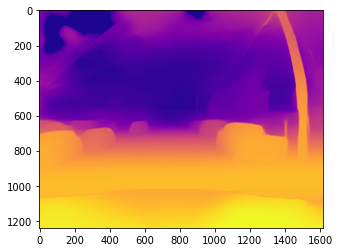

In [ ]:
def prediction_stream(image, seg_map, seg_data, frame, index):
    """Visualizes segmentation overlay view and stream it with IPython display."""
    for i in range(len(seg_map)):
        for j in range(len(seg_map[i])):
                seg_data[i][j] = LABEL_NAMES[seg_map[i][j]]

    img = frame
    input_batch = transform(img).to(device)

    with torch.no_grad():
      prediction = midas(input_batch)

      prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
      ).squeeze()

    output = prediction.cpu().numpy()
    output = 50*output/np.max(output)     #normalization due to the 
    plt.imshow(expand(output), cmap='plasma')
    A = np.stack([seg_data,output])

    # # Show visualization in a streaming fashion.
    # f = BytesIO()
    # plt.savefig(f, format='jpeg')
    # IPython.display.display(IPython.display.Image(data=f.getvalue()))
    # f.close()
    # plt.close()
    return A
def prediction_video(frame, index):
    """Inferences DeepLab model on a video file and stream the visualization."""
    original_im = Image.fromarray(frame[..., ::-1])
    seg_map = MODEL.run(original_im)
    seg_data = np.full((len(seg_map),len(seg_map[0])),'nullvoidnada')
    filled_seg_data = prediction_stream(original_im, seg_map, seg_data, frame, index)
    # print(filled_seg_data)
    return filled_seg_data
    

SAMPLE_VIDEO = 'test12.mp4'
print('running deeplab on the sample video...')

video = cv.VideoCapture(SAMPLE_VIDEO)
# num_frames = 598  # uncomment to use the full sample video
num_frames = 5

try:
    for i in range(num_frames):
        _, frame = video.read()
        if not _: break
        filled_seg_DATA = prediction_video(frame, i)
        IPython.display.clear_output(wait=True)
except KeyboardInterrupt:
    plt.close()
    print("Stream stopped.")
print(filled_seg_DATA)